In [1]:
!pip install numpy pandas scikit-learn matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# List of participant IDs and number of files per participant
participants = [1, 2, 3, 4]  # Assuming 4 participants
num_files_per_participant = 10  # Assuming 10 files per participant

# Function to load data from all files
def load_all_eda_data(participants, num_files):
    all_data = []
    for participant in participants:
        for file_num in range(1, num_files+1):
            file_path = f'EDA_{participant}_{file_num}.csv'  # Adjust the path
            df = pd.read_csv(file_path, skiprows=3, header=None)
            df.columns = ['EDA']
            df['Participant'] = participant
            df['File'] = file_num
            all_data.append(df)

    # Concatenate all dataframes
    full_data = pd.concat(all_data, ignore_index=True)
    return full_data

# Load all EDA data
eda_data = load_all_eda_data(participants, num_files_per_participant)

# Check the data
print(eda_data.head())


        EDA  Participant  File
0  0.286725            1     1
1  0.344326            1     1
2  0.343046            1     1
3  0.343046            1     1
4  0.339206            1     1


In [19]:
# Placeholder function to extract phasic and tonic components
def extract_phasic_tonic(eda_signal):
    # Simplified example of extraction using rolling average
    phasic_component = eda_signal.rolling(window=20).mean()  # Simplified for illustration
    tonic_component = eda_signal - phasic_component  # Simplified for illustration
    return phasic_component, tonic_component

# Extract Phasic and Tonic components for the entire dataset
eda_data['Phasic'], eda_data['Tonic'] = extract_phasic_tonic(eda_data['EDA'])

# Drop any NaN values that resulted from rolling operations
eda_data.dropna(inplace=True)

# Check the updated data
print(eda_data.head())


         EDA  Participant  File    Phasic     Tonic
19  0.321285            1     1  0.327237 -0.005952
20  0.320005            1     1  0.328901 -0.008896
21  0.320005            1     1  0.327685 -0.007680
22  0.318725            1     1  0.326469 -0.007744
23  0.318725            1     1  0.325253 -0.006528


In [20]:
# Split data into train (70%), validation (15%), and test (15%)
train_val_data, test_data = train_test_split(eda_data, test_size=0.15, shuffle=False)
train_data, val_data = train_test_split(train_val_data, test_size=0.176, shuffle=False)

print(f"Train shape: {train_data.shape}, Validation shape: {val_data.shape}, Test shape: {test_data.shape}")


Train shape: (71239, 5), Validation shape: (15217, 5), Test shape: (15257, 5)


In [21]:
def create_features(df, n_lags=5):
    # Create lag features for both Phasic and Tonic components
    for lag in range(1, n_lags + 1):
        df[f'Phasic_lag_{lag}'] = df['Phasic'].shift(lag)
        df[f'Tonic_lag_{lag}'] = df['Tonic'].shift(lag)

    # Drop rows with NaN values due to lagging
    df.dropna(inplace=True)
    return df

# Apply feature engineering on training, validation, and test sets
train_data = create_features(train_data)
val_data = create_features(val_data)
test_data = create_features(test_data)

# Define the features (lag features) and target (EDA)
features = [col for col in train_data.columns if 'lag' in col]
target = 'EDA'


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score, recall_score

# Initialize the model
model = LinearRegression()

# Train the model
X_train = train_data[features]
y_train = train_data[target]
model.fit(X_train, y_train)

# Predict on validation set
X_val = val_data[features]
y_val = val_data[target]
y_pred = model.predict(X_val)

# Evaluate the model using RMSE, Accuracy, F1, Sensitivity (Recall), AUROC
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

# Convert to binary classification (trend prediction) for other metrics
y_pred_binary = np.where(y_pred > y_val.mean(), 1, 0)  # Predicting trend up or down
y_val_binary = np.where(y_val > y_val.mean(), 1, 0)

accuracy = accuracy_score(y_val_binary, y_pred_binary)
f1 = f1_score(y_val_binary, y_pred_binary)
sensitivity = recall_score(y_val_binary, y_pred_binary)
auroc = roc_auc_score(y_val_binary, y_pred_binary)

print(f"Accuracy: {accuracy}, F1: {f1}, Sensitivity: {sensitivity}, AUROC: {auroc}")


Validation RMSE: 0.02857097675723127
Accuracy: 0.9949382066789377, F1: 0.9937707305234205, Sensitivity: 0.9936903413687106, AUROC: 0.9947413062175189


In [23]:
# Predict on test set
X_test = test_data[features]
y_test = test_data[target]
y_test_pred = model.predict(X_test)

# Calculate metrics on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
y_test_pred_binary = np.where(y_test_pred > y_test.mean(), 1, 0)
y_test_binary = np.where(y_test > y_test.mean(), 1, 0)

accuracy_test = accuracy_score(y_test_binary, y_test_pred_binary)
f1_test = f1_score(y_test_binary, y_test_pred_binary)
sensitivity_test = recall_score(y_test_binary, y_test_pred_binary)
auroc_test = roc_auc_score(y_test_binary, y_test_pred_binary)

print(f"Test RMSE: {rmse_test}, Test Accuracy: {accuracy_test}, F1: {f1_test}, Sensitivity: {sensitivity_test}, AUROC: {auroc_test}")


Test RMSE: 0.04081680988872496, Test Accuracy: 0.994230264883294, F1: 0.994230264883294, Sensitivity: 0.9937090432503276, AUROC: 0.9942305384186564


In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define a function to prepare the data for LSTM
def create_lstm_data(df, target, features, time_steps=10):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[features].iloc[i:i+time_steps].values)
        y.append(df[target].iloc[i+time_steps])  # Predict the EDA value after the time window
    return np.array(X), np.array(y)

# Standardize the data (LSTMs work better when the data is scaled)
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])
test_data[features] = scaler.transform(test_data[features])

# Create sequential data for LSTM
time_steps = 10  # You can experiment with different time steps
X_train, y_train = create_lstm_data(train_data, target, features, time_steps)
X_val, y_val = create_lstm_data(val_data, target, features, time_steps)
X_test, y_test = create_lstm_data(test_data, target, features, time_steps)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



X_train shape: (71224, 10, 10), y_train shape: (71224,)
X_val shape: (15202, 10, 10), y_val shape: (15202,)
X_test shape: (15242, 10, 10), y_test shape: (15242,)


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# Add an LSTM layer with dropout (to prevent overfitting)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (regression output, hence no activation function)
model.add(Dense(units=1))

# Compile the model (for regression, we use 'mse' loss)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Check the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 0.0058 - val_loss: 0.1726
Epoch 2/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - loss: 0.0011 - val_loss: 0.1399
Epoch 3/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 8.4855e-04 - val_loss: 0.1225
Epoch 4/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 8.1403e-04 - val_loss: 0.1741
Epoch 5/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 7.6415e-04 - val_loss: 0.2279
Epoch 6/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 8.2853e-04 - val_loss: 0.2226
Epoch 7/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 8.0322e-04 - val_loss: 0.2343
Epoch 8/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 7.4774e-04 - val_loss: 0.2160
Epoch 9/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 7.2797e-04 - val_loss: 0.2177
Epoch 10/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 6.6355e-04 - val_loss: 0.2428
Epoch 11/20
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 8.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,355 (380.30 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,904 (253.54 KB)

In [26]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, roc_auc_score

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate RMSE for validation set
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {rmse_val}")

# Convert predictions to binary trend (for classification metrics)
y_val_pred_binary = np.where(y_val_pred > y_val.mean(), 1, 0)
y_val_binary = np.where(y_val > y_val.mean(), 1, 0)

accuracy_val = accuracy_score(y_val_binary, y_val_pred_binary)
f1_val = f1_score(y_val_binary, y_val_pred_binary)
sensitivity_val = recall_score(y_val_binary, y_val_pred_binary)
auroc_val = roc_auc_score(y_val_binary, y_val_pred_binary)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Sensitivity: {sensitivity_val}")
print(f"Validation AUROC: {auroc_val}")

# Repeat the process for the test set
y_test_pred = model.predict(X_test)

# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {rmse_test}")

y_test_pred_binary = np.where(y_test_pred > y_test.mean(), 1, 0)
y_test_binary = np.where(y_test > y_test.mean(), 1, 0)

accuracy_test = accuracy_score(y_test_binary, y_test_pred_binary)
f1_test = f1_score(y_test_binary, y_test_pred_binary)
sensitivity_test = recall_score(y_test_binary, y_test_pred_binary)
auroc_test = roc_auc_score(y_test_binary, y_test_pred_binary)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Sensitivity: {sensitivity_test}")
print(f"Test AUROC: {auroc_test}")



476/476 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Validation RMSE: 0.5022029498240278
Validation Accuracy: 0.9880936718852783
Validation F1 Score: 0.9851724420414517
Validation Sensitivity: 0.9736075129533679
Validation AUROC: 0.9858066370439341
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test RMSE: 0.3097813080467054
Test Accuracy: 0.8986353496916415
Test F1 Score: 0.8873167529720662
Test Sensitivity: 0.7982939632545932
Test AUROC: 0.898622184985995


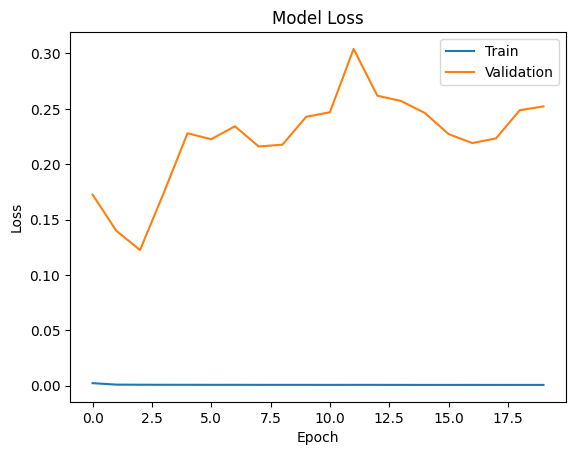

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


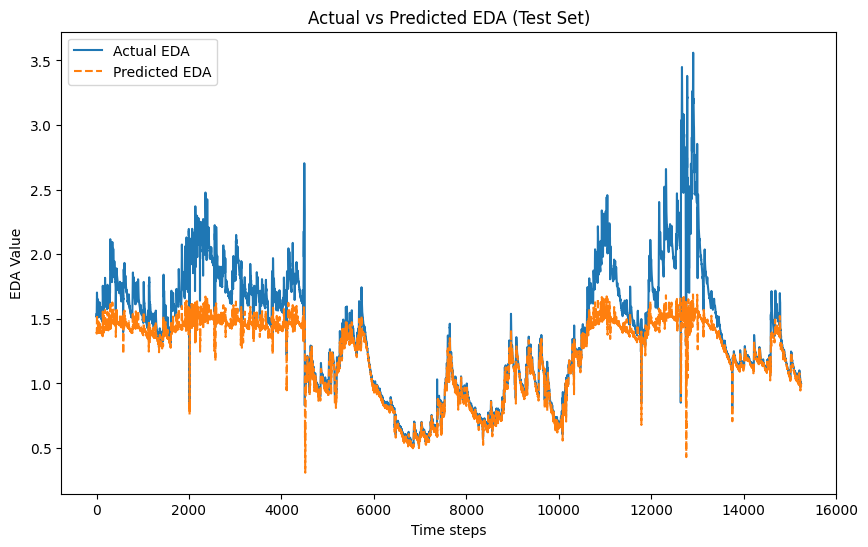

In [28]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values on the test set
def plot_actual_vs_predicted(y_actual, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(10, 6))
    plt.plot(y_actual, label='Actual EDA')
    plt.plot(y_pred, label='Predicted EDA', linestyle='dashed')
    plt.title(title)
    plt.xlabel('Time steps')
    plt.ylabel('EDA Value')
    plt.legend()
    plt.show()

# Predict on test data
y_test_pred = model.predict(X_test)

# Plot the actual vs predicted EDA values on the test set
plot_actual_vs_predicted(y_test, y_test_pred, title="Actual vs Predicted EDA (Test Set)")
